Imports

In [30]:
# Data Processing Modules
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


# SentencePiece
import sentencepiece as spm

# Word2Vec
from gensim.models import Word2Vec

# Model Evaluation
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# Model Creation
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset
import torch.optim as optim

import gensim.downloader as api

In [31]:
glove_model = api.load("glove-twitter-25")

In [32]:
def get_avg_vector_for_sent_glove(tokens, model):
    '''Uses the GloVe model to get the vector representation of the tokens 
       in a sentence and takes the mean.'''
    vector = np.zeros(model.vector_size)
    num_tokens = 0
    for token in tokens:
        if token in model.key_to_index:  # Checking if the token is in the GloVe vocabulary
            vector += model.get_vector(token)
            num_tokens += 1
    if num_tokens > 0:
        vector /= num_tokens
    return vector
    
def sentence_to_vector_glove(sentence, model):
    '''Returns the vector representation of a sentence
       by taking the average of the GloVe representations of the words.'''
    tokens = sp.encode_as_pieces(sentence)  # Assuming you are still using SentencePiece for tokenization
    vector = get_avg_vector_for_sent_glove(tokens, model)
    return vector


In [33]:
torch.__version__  

'2.3.0.dev20240312'

Check model is set to CUDA / MPS

In [34]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [35]:
# if torch.backends.mps.is_available(): # TODO: Handle CUDA
#     mps_device = torch.device("mps")
#     x = torch.ones(1, device=mps_device)
#     print (x)
# else:
#     print ("MPS device not found.")

Load Dataset

In [36]:
file_path = './data/TitlesAndScoreALL.csv'
data_df = pd.read_csv(file_path, sep=',')

In [37]:
data_df['title'] = data_df['title'].str.lower()

In [38]:
def dataframe_sentence_generator(df):
    for sentence in df:
        yield sentence
        
spm.SentencePieceTrainer.train(
    sentence_iterator=dataframe_sentence_generator(data_df['title']), 
    vocab_size=12_828,
    model_prefix='./data/spm_model', 
    model_type='unigram',
)

sp = spm.SentencePieceProcessor()

Load the SentencePiece model

In [39]:
sp.load('./data/spm_model.model')

True

Tokenizer

In [40]:
def get_sentence_tokens(sentence):
    '''Gets the word tokens of a given sentence by tokenising'''
    tokens = sp.encode_as_pieces(sentence)
    return tokens

def get_avg_vector_for_sent(tokens, model):
    '''Uses the Word2Vec LUT to get the vector representation of a tokens 
       in a sentence and takes the mean'''
    vector = np.zeros(model.vector_size)
    for token in tokens:
        if token in model.wv:
            vector += model.wv[token]
    if len(tokens) > 0: 
        vector /= len(tokens)
    return vector
    
def sentence_to_vector(sentence, model):
    '''Returns the vector representation of a sentence
       by taking the average of the Word2Vec representations of the 
       words / subwords'''
    tokens = get_sentence_tokens(sentence)
    vector = get_avg_vector_for_sent(tokens, model)
    return vector


In [41]:
word_dimensionality = 25

In [42]:
# class Word2Vec: # TODO: Define custom Word2Vec class
#     def __init__(sentences=tokens_list, vector_size=word_dimensionality, window=5, min_count=1, workers=4):
#         pass

In [43]:
# Create a scaler object
# scaler = StandardScaler()

# Fit the scaler to the data and transform the data
# data_df['score'] = scaler.fit_transform(data_df[['score']])

In [44]:
# tokenized_titles = [sp.encode_as_pieces(title) for title in data_df['title']]
# word2vec_model = Word2Vec(sentences=tokenized_titles, vector_size=word_dimensionality, window=5, min_count=1, workers=4)
# data_df['sentence_vector'] = data_df['title'].apply(lambda x: sentence_to_vector(x, word2vec_model))

In [45]:
# Assuming data_df is your DataFrame and it contains a column 'title'
data_df['sentence_vector'] = data_df['title'].apply(lambda x: sentence_to_vector_glove(x, glove_model))


In [46]:
# Printing the path to the downloaded GloVe model for verification
# glove_path = api.load('glove-wiki-gigaword-50', return_path=True)
# print(glove_path)

In [47]:
data_df.head()

,id,title,score,sentence_vector
0,442106,"for peruvians, baskets for the u.s. market bri...",1,"[0.6605812571942806, -0.21765875816345215, -0...."
1,442112,wsj.com : president obama's inaugural address,1,"[0.8612800166010857, -0.6965750232338905, 0.06..."
2,551087,smart way to share psd files using diff and patch,1,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
3,551119,download yahoo messenger for iphone,1,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
4,551165,reinventing the conference call,1,"[0.5053399801254272, 0.958899974822998, 0.2512..."


In [48]:
data_df['sentence_vector'][0].shape

(25,)

Train Test Split

In [49]:
# Split the data into training and test sets
X_train, X_test_and_val, y_train, y_test_and_val = train_test_split(
    data_df['sentence_vector'].tolist(), 
    data_df['score'], 
    test_size=0.3, 
    random_state=42
)

X_test, X_val, y_test, y_val = train_test_split(
    X_test_and_val, 
    y_test_and_val, 
    test_size=0.5, 
    random_state=42
)

In [50]:
X_train = torch.tensor(np.vstack(X_train), dtype=torch.float32).to(device)
y_train = torch.tensor(np.array(y_train), dtype=torch.float32).view(-1, 1).to(device)

X_val = torch.tensor(np.vstack(X_val), dtype=torch.float32).to(device)
y_val = torch.tensor(np.array(y_val), dtype=torch.float32).view(-1, 1).to(device)

X_test = torch.tensor(np.vstack(X_test), dtype=torch.float32).to(device)
y_test = torch.tensor(np.array(y_test), dtype=torch.float32).view(-1, 1).to(device)


Model

In [51]:
class UpvotesPredictorNN(nn.Module):
    def __init__(self, dropout_rate=0.5):
        super(UpvotesPredictorNN, self).__init__()
        
        # Input layer to 1st hidden layer
        self.fc1 = nn.Linear(word_dimensionality, 128)
        self.relu1 = nn.ReLU()
        
        # 1st hidden layer to 2nd hidden layer
        self.fc2 = nn.Linear(128, 32)
        self.relu2 = nn.ReLU()
        
        # 2nd hidden layer to output layer
        self.output = nn.Linear(32, 1)
        
    def forward(self, x):
        x = self.relu1(self.fc1(x))
        x = self.relu2(self.fc2(x))
        output = self.output(x)
        return output

In [52]:
# # Define model and hyperparameters
# model = UpvotesPredictorNN().to(device)
# criterion = nn.MSELoss()
# num_epochs = 500
# optimizer = optim.Adam(model.parameters(), lr=0.01)

# # Batching
# batch_size = 64

# train_dataset = TensorDataset(X_train, y_train)  
# train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

# val_dataset = TensorDataset(X_val, y_val)
# val_loader = DataLoader(TensorDataset(X_val, y_val), batch_size=batch_size, shuffle=False)



# # Storage object for data vis
# list_of_lists = []

# # Training loop
# for epoch in range(num_epochs):
#     # Set model to training mode
#     model.train()
#     for batch_idx, (data,target) in enumerate(train_loader):
#         data, target = data.to(device), target.to(device)
#         optimizer.zero_grad()
#         outputs = model(data)
#         loss = criterion(outputs, target)
#         loss.backward()
#         optimizer.step()
    
#     # Set model to evaluation mode
#     model.eval()
#     val_loss = 0
#     with torch.no_grad():
#         for data, target in val_loader:
#             data, target = data.to(device), target.to(device)
#             val_out = model(X_val)
#             val_loss = criterion(val_out, y_val)
    
#     # Store loss for data vis
#     list_of_lists.append([epoch, loss.item(), val_loss.item()])
    
#     # Logging
#     if epoch % 100 == 0:
#         print(f'Epoch {epoch+1},\t Train Loss: {loss.item()},\t Val Loss: {val_loss.item()}')

In [53]:
# Define model and hyperparameters
model = UpvotesPredictorNN().to(device)
criterion = nn.MSELoss()
num_epochs = 10_000
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Batching
# batch_size = 64

# train_dataset = TensorDataset(X_train, y_train)
# train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

# val_dataset = TensorDataset(X_val, y_val)
# val_loader = DataLoader(TensorDataset(X_val, y_val), batch_size=batch_size, shuffle=False)



# Storage object for data vis
list_of_lists = []

# Training loop
for epoch in range(num_epochs):
    # Set model to training mode
    model.train()
    optimizer.zero_grad()
    outputs = model(X_train.to(device))
    loss = criterion(outputs, y_train.to(device))
    loss.backward()
    optimizer.step()
    
    
    # Set model to evaluation mode
    model.eval()
    val_loss = 0
    with torch.no_grad():
        predictions = model(X_test.to(device))
        val_loss = criterion(predictions, y_test.to(device))
    
    # Store loss for data vis
    list_of_lists.append([epoch, loss.item(), val_loss.item()])
    
    # # Logging

    # if epoch % 10 == 0:
    #     print(f'Epoch {epoch+1},\t Train Loss: {loss.item()},\t Val Loss: {val_loss.item()}')

In [54]:
train_loss_list = []
val_loss_list = []
epoch_list = []

for i,j,k in list_of_lists:
    epoch_list.append(i)
    train_loss_list.append(j)
    val_loss_list.append(k)

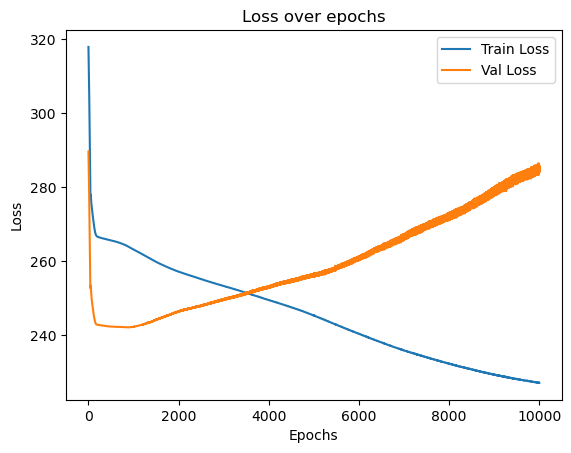

In [55]:
plt.plot(epoch_list, train_loss_list, label='Train Loss')
plt.plot(epoch_list, val_loss_list, label='Val Loss')
plt.title('Loss over epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [56]:
with torch.no_grad():
    model.eval()
    predictions = model(X_test)
    test_loss = criterion(predictions, y_test) 

print(f'Test Loss: {test_loss.item()}')

Test Loss: 284.0851135253906


In [74]:
np.argmax(y_test.cpu().numpy())

20711

In [75]:
index_to_check = 20711

with torch.no_grad():
    model.eval()
    predictions = model(X_test)

specific_test_example = X_test[index_to_check]
predicted_value = predictions[index_to_check]
actual_value = y_test[index_to_check]

print("Original Sentence:", data_df['title'].iloc[index_to_check])
print("Predicted Upvotes Value:", predicted_value.item())
print("Actual Upvotes Value:", actual_value.item())

Original Sentence: only the beginning
Predicted Upvotes Value: 8.41806411743164
Actual Upvotes Value: 532.0


EDA

In [59]:
print(data_df['score'].describe())


count    165806.000000
mean          7.180512
std          16.401199
min           0.000000
25%           1.000000
50%           2.000000
75%           5.000000
max         928.000000
Name: score, dtype: float64


c:\Users\jacob\miniconda3\envs\mlx4-2\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


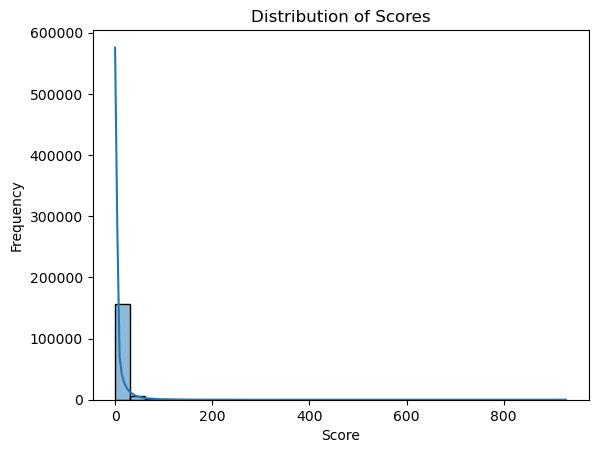

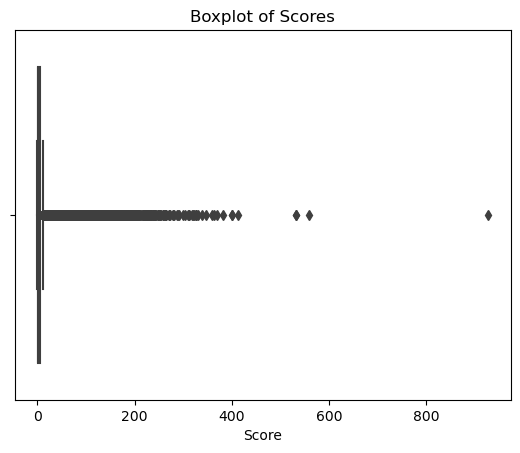

In [60]:

# Histogram of scores
sns.histplot(data_df['score'], bins=30, kde=True)
plt.title('Distribution of Scores')
plt.xlabel('Score')
plt.ylabel('Frequency')
plt.show()

# Boxplot for outlier visualization
sns.boxplot(x=data_df['score'])
plt.title('Boxplot of Scores')
plt.xlabel('Score')
plt.show()


In [61]:
print("Skewness: %f" % data_df['score'].skew())
print("Kurtosis: %f" % data_df['score'].kurt())


Skewness: 7.896909
Kurtosis: 146.022585


c:\Users\jacob\miniconda3\envs\mlx4-2\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


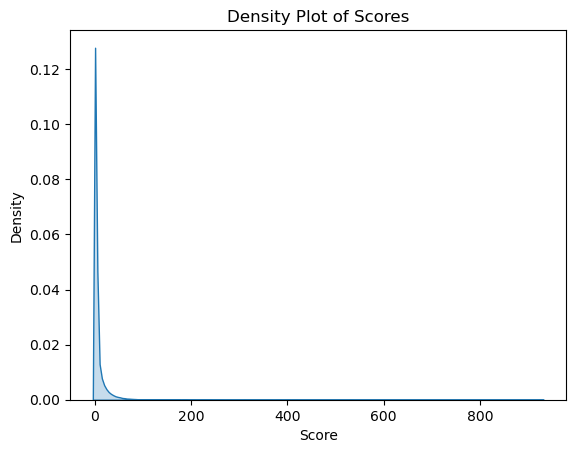

In [62]:
sns.kdeplot(data_df['score'], fill=True)
plt.title('Density Plot of Scores')
plt.xlabel('Score')
plt.ylabel('Density')
plt.show()
